In [1]:
import os
from sklearn import preprocessing
import statsmodels.api as sm
import missingpy
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score

In [2]:
folder="D:\\smarcitiesdata"
list_of_database=os.listdir(folder)

dataframe=pd.read_csv(folder+"\\"+list_of_database[3])
dataframe.set_index('tempo',inplace=True)
dataframe.index=pd.to_datetime(dataframe.index)

dataframe['week_day']=dataframe.index.weekday
dataframe['hour']=dataframe.index.hour
temporal_variables=['week_day','hour']

passages_variables=pd.read_csv(folder+"\\"+list_of_database[4])
passages_variables=list(passages_variables['passages_variables'])
passages_variables_smoothed=pd.read_csv(folder+"\\"+list_of_database[5])
passages_variables_smoothed=list(passages_variables_smoothed['passages_variables_smoothed'])
weather_variables=pd.read_csv(folder+"\\"+list_of_database[8])
weather_variables=list(weather_variables['weather_variables'])
weather_variables_smoothed=pd.read_csv(folder+"\\"+list_of_database[9])
weather_variables_smoothed=list(weather_variables_smoothed['weather_variables_smoothed'])
covariates=passages_variables+passages_variables_smoothed+weather_variables+weather_variables_smoothed+temporal_variables

In [3]:
sunday_dummy=[]
for daynumb in dataframe.index.weekday:
    if daynumb==6:
        x=1
    else:
        x=0    
    sunday_dummy.append(x)

saturday_dummy=[]
for daynumb in dataframe.index.weekday:
    if daynumb==5:
        x=1
    else:
        x=0
    saturday_dummy.append(x)

dataframe['sunday_dummy']=sunday_dummy
dataframe['saturday_dummy']=saturday_dummy
covariates.append('sunday_dummy')
covariates.append('saturday_dummy')

## Compute AIR quality index Hourly

In [4]:
def compute_air_quality_index(dataframe):
    # INDEX FOR PM10
    PM10 = (dataframe["PM10 (SM2005)"]/50)*100 
    INDEX_PM10 = pd.DataFrame(PM10)  
    INDEX_PM10.columns = ["INDEX_PM10"]

    # INDEX FOR NITROGENE DIOXIDE
    I_NO2 = (dataframe["Nitrogene Dioxide"]/200)*100
    I_NO2.columns = ["INDEX_NO2"] 
    INDEX_NO2 = I_NO2.reset_index(drop=True)

    # INDEX FOR OZONE
    Oz = dataframe["Ozone"].rolling(8, min_periods = 1).max() # we use the moving window to compute the moving maximum value in the 8 hours for ozone
    NO3 = pd.DataFrame(Oz)
    # we calculate the index
    I_NO3 = (NO3/120)*100
    I_NO3.columns = ["INDEX_NO3"]
    INDEX_NO3 = I_NO3.reset_index(drop = True)


    ### We construct the AIR QUALITY INDEX (IQA) using the formula ###

    AIR_QUALITY_IN =(np.array(INDEX_PM10).T.squeeze() + pd.concat([INDEX_NO2, INDEX_NO3], axis = 1).apply(max, axis =1))/2   # IQA
    dataframe['AIR_QUALITY_INDEX']=np.array(AIR_QUALITY_IN)
    return dataframe
dataframe=compute_air_quality_index(dataframe)
pollution_list=list(dataframe.columns[0:10])
pollution_list.append('AIR_QUALITY_INDEX')

## RIDGE

In [12]:
list_of_predictions_ridge=[]
list_of_errors_ridge=[]
for pollutant in pollution_list:
    X=dataframe.loc[:,covariates]
    y=dataframe.loc[:,pollutant]
    ## scale for ridge
    X=preprocessing.scale(X.astype('float64'))
    #### split
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
    model=RidgeCV()
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    list_of_predictions_ridge.append(predictions)
    list_of_errors_ridge.append(predictions-y_test)

## Support Vector Machines

In [5]:
list_of_predictions_SVM=[]
list_of_errors_SVM=[]
for pollutant in pollution_list:
    X=dataframe.loc[:,covariates]
    y=dataframe.loc[:,pollutant]
    ## scale for ridge
    X=preprocessing.scale(X.astype('float64'))
    #### split
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
    model=svm.SVR(gamma='scale',kernel='poly')
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    list_of_predictions_SVM.append(predictions)
    list_of_errors_SVM.append(predictions-y_test)

## Neural Network

In [6]:
list_of_predictions_NN=[]
list_of_errors_NN=[]
list_of_history_NN=[]
for pollutant in pollution_list:
    X=dataframe.loc[:,covariates]
    y=dataframe.loc[:,pollutant]
    ## scale for ridge
    X=preprocessing.scale(X.astype('float64'))
    #### split
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
    ## build the neural network
    model = keras.Sequential([layers.Dense(50, activation='linear', input_shape=[X_train.shape[1]]),layers.Dense(100, activation=tf.nn.relu),layers.Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mean_absolute_error', 'mean_squared_error'])
    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150)
    
    ### Try to increase the epochs and patience if results are unsatisfactory
    
    history = model.fit(X_train, y_train,epochs=250, validation_split = 0.2, verbose=0,callbacks=[early_stop])
    
    
    predictions=model.predict(X_test).flatten()
    list_of_predictions_NN.append(predictions)
    list_of_errors_NN.append(predictions-y_test)
    list_of_history_NN.append(history)
    print('done')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
done
done
done
done
done
done
done
done
done
done
done


## Random Forest

In [7]:
list_of_predictions_RF=[]
list_of_errors_RF=[]
for pollutant in pollution_list:
    X=dataframe.loc[:,covariates]
    y=dataframe.loc[:,pollutant]
    ## scale for ridge
    X=preprocessing.scale(X.astype('float64'))
    #### split
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
    model=RandomForestRegressor(n_estimators=10)
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    list_of_predictions_RF.append(predictions)
    list_of_errors_RF.append(predictions-y_test)

# Visualize results for each pollutant

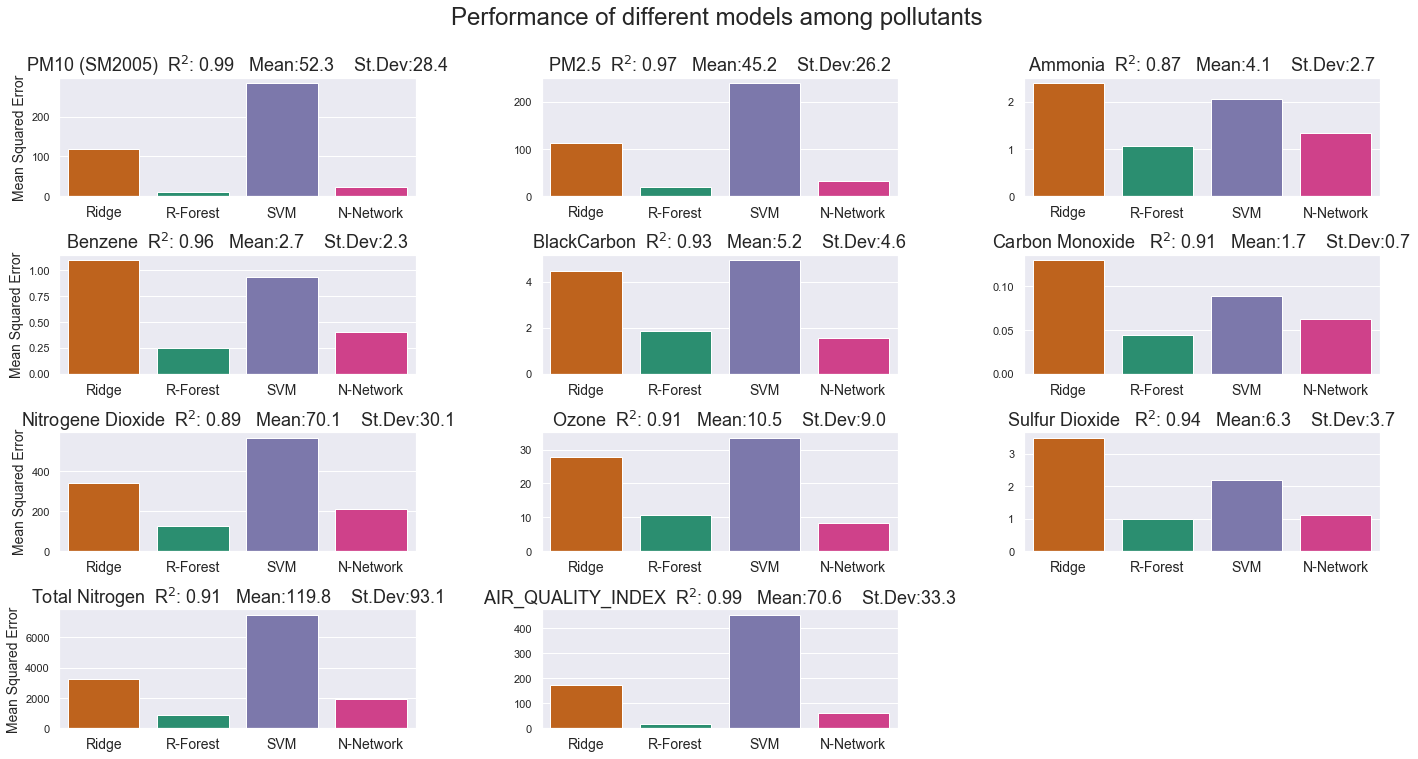

In [80]:
list_of_all_errors=[list_of_errors_ridge,list_of_errors_RF,list_of_errors_SVM,list_of_errors_NN]
list_of_pollutants=pollution_list

def compute_mse(array_of_errors):
    mse_error=np.mean(np.array(array_of_errors)**2)
    return mse_error

def compute_rsquared(array_of_errors,array_of_actuals):
    numerator=np.sum(np.array(array_of_errors)**2)
    mean_actual=np.mean(array_of_actuals)
    denominator=np.sum((np.array(array_of_actuals)-mean_actual)**2)
    r_squared=1-(numerator/denominator)
    return r_squared


fig,axs=plt.subplots(4,3,figsize=(20,10))
i=0
for pollutant in list_of_pollutants:
    list_of_errors=[]
    list_of_rsquared=[]
    for model_error in list_of_all_errors:
        list_of_errors.append(compute_mse(model_error[i]))
        list_of_rsquared.append(compute_rsquared(model_error[i],dataframe.loc[y_test.index,pollutant]))
    sns.barplot(x=['Ridge','R-Forest','SVM','N-Network'],y=list_of_errors,ax=axs.flatten()[i],palette=['#d95f02','#1b9e77','#7570b3','#e7298a'])
    axs.flatten()[i].set_title("{0}  R$^2$: {1}   Mean:{2}    St.Dev:{3}".format(pollutant,round(np.max(list_of_rsquared),2),round(dataframe[pollutant].mean(),1),round(dataframe[pollutant].std(axis=0),1)),fontsize=18)
    axs.flatten()[i].tick_params(axis='x',labelsize=14)
    l=axs.flatten()[i].get_ylabel()
    axs.flatten()[i].set_ylabel(l,fontsize=14)
    i+=1
    if i>=len(list_of_pollutants):
        axs.flatten()[i].set_axis_off()


for x in range(0,4):
    axs[x,0].set_ylabel('Mean Squared Error')

fig.suptitle('Performance of different models among pollutants',fontsize=24,y=1.05)
plt.tight_layout()

#### ## predicting AIR QUALITY INDEX
- through other predictions
- directly regression
- using regression for class
- directly through classification

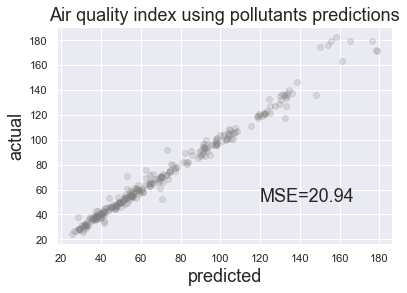

In [65]:
### we merge actual and  predict to compute AQI from our predictions
predicted_hours=list_of_errors_RF[0].index
dataframe_merged_predicted_actual=dataframe.copy()
variables_for_AQI=['PM10 (SM2005)','Nitrogene Dioxide','Ozone']
for variab_AQI in variables_for_AQI:
    dataframe_merged_predicted_actual.loc[predicted_hours,variab_AQI]=list_of_predictions_RF[list_of_pollutants.index(variab_AQI)]

# compute the air quality index...
dataframe_merged_predicted_actual=compute_air_quality_index(dataframe_merged_predicted_actual)    
predictions=dataframe_merged_predicted_actual.loc[predicted_hours,'AIR_QUALITY_INDEX']
actuals=dataframe.loc[predicted_hours,'AIR_QUALITY_INDEX']

plt.scatter(x=predictions,y=actuals,color='grey',alpha=0.2);
plt.xlabel('predicted',fontsize=18)
plt.ylabel('actual',fontsize=18);
plt.title('Air quality index using pollutants predictions',fontsize=18)
plt.text(s='MSE={0}'.format(round(compute_mse(np.array(predictions-actuals)),2)),x=120,y=50,fontsize=18);

#print('Results are very good but of course they are driven by the facgt that we are using actual....')


## Regress directly air quality....work with RF and NN

##### stratified sampling

In [66]:
pollutant='AIR_QUALITY_INDEX'
y_target=dataframe.loc[:,pollutant]
bins=np.linspace(0,len(y_target),20)
y_binned = np.digitize(y_target,bins)

### to pass it just pass y_binned to the "stratify=y_binned" in train_test_split

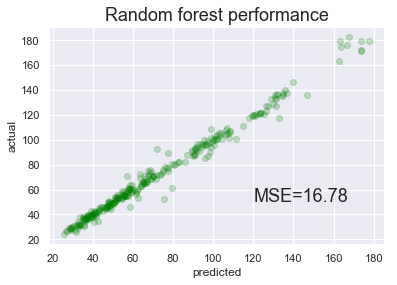

In [67]:
pollutant='AIR_QUALITY_INDEX'
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,pollutant]
## scale 
X=preprocessing.scale(X.astype('float64'))
#### split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
## i.e. number of estimators is the number of trees
model=RandomForestRegressor(n_estimators=100)
model.fit(X_train,y_train)
predictions=model.predict(X_test)
plt.scatter(x=predictions,y=y_test,color='green',alpha=0.2)
plt.title('Random forest performance',fontsize=18);
plt.xlabel('predicted')
plt.ylabel('actual');
plt.text(s='MSE={0}'.format(round(compute_mse(np.array(predictions-y_test)),2)),x=120,y=50,fontsize=18);


In [ ]:
pollutant='AIR_QUALITY_INDEX'
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,pollutant]
## scale 
X=preprocessing.scale(X.astype('float64'))
#### split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
## i.e. number of estimators is the number of trees
mse_error_list=[]
number_of_trees_list=[]
for numb_tree in range(10,500,10):
    number_of_trees_list.append(numb_tree)
    model=RandomForestRegressor(n_estimators=numb_tree)
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    mse_error_list.append(compute_mse(np.array(predictions-y_test)))

plt.scatter(x=number_of_trees_list,y=mse_error_list,color='green')
plt.xlabel('Number of treees')
plt.ylabel('Mean Squared Errors')
plt.title('Number of trees VS performance');

## Variable importance using Ridge

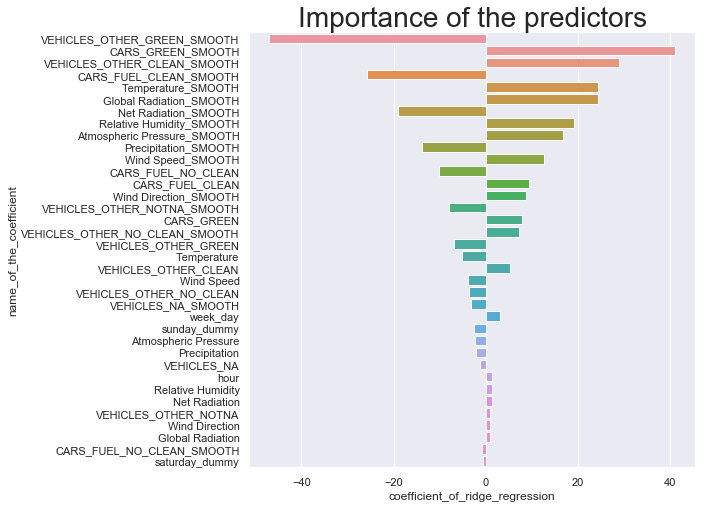

In [103]:
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,'AIR_QUALITY_INDEX']
## scale for ridge
X=preprocessing.scale(X.astype('float64'))
#### split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
model=RidgeCV()
model.fit(X_train,y_train)
variable_importance=pd.DataFrame({'name_of_the_coefficient':covariates,'coefficient_of_ridge_regression':model.coef_,'absolute_coefficient':abs(model.coef_)})
variable_importance.sort_values('absolute_coefficient',ascending=False,inplace=True)
plt.figure(figsize=(8,8))
plt.title('Importance of the predictors',fontsize=28)
barplot_importance=sns.barplot(variable_importance['coefficient_of_ridge_regression'],variable_importance['name_of_the_coefficient'],orient="h")


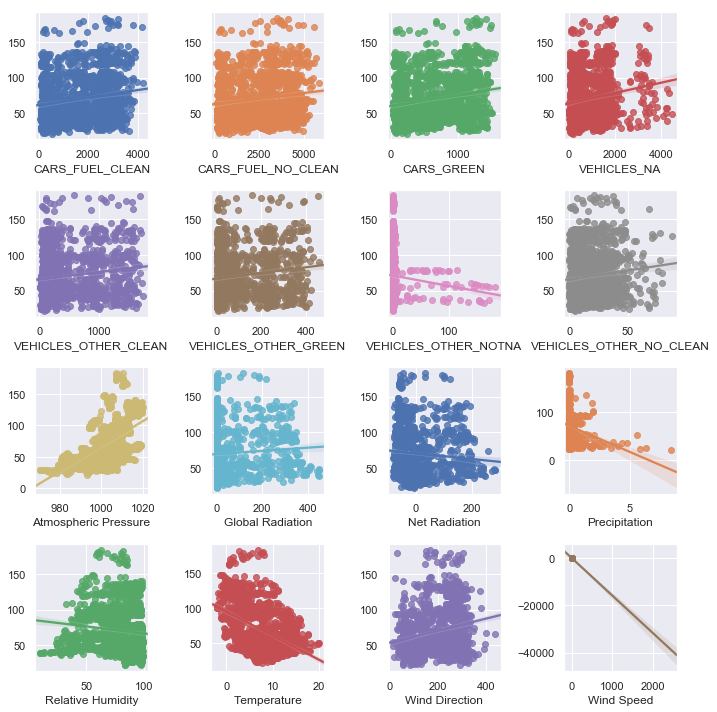

In [104]:
### original variables
original_vars=passages_variables+weather_variables
fig,axs=plt.subplots(4,4,figsize=(10,10))
i=0
for vare in original_vars:
    sns.regplot(y=dataframe['AIR_QUALITY_INDEX'],x=dataframe[vare],ax=axs.flatten()[i])
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].set_xlabel(vare)
    i+=1

plt.tight_layout()

# Classification predictions

In [105]:
### WE DIVIDE THE AIR QUALITY INDEX INTO MULTIPLE CLASSES (7 CLASSES)
dataframe['AIR_QUALITY_INDEX_CLASS'] = dataframe['AIR_QUALITY_INDEX']
bool_mask=dataframe['AIR_QUALITY_INDEX']

dataframe.loc[(bool_mask<50),'AIR_QUALITY_INDEX_CLASS']=0
dataframe.loc[(bool_mask >=50) & (bool_mask <75),'AIR_QUALITY_INDEX_CLASS'] =1 
dataframe.loc[(bool_mask >=75) & (bool_mask <100),'AIR_QUALITY_INDEX_CLASS'] = 2 
dataframe.loc[(bool_mask >=100) & (bool_mask <125),'AIR_QUALITY_INDEX_CLASS'] = 3
dataframe.loc[(bool_mask >124) & (bool_mask <150),'AIR_QUALITY_INDEX_CLASS'] = 4 
dataframe.loc[(bool_mask >149) & (bool_mask <175),'AIR_QUALITY_INDEX_CLASS'] = 5
dataframe.loc[(bool_mask>174),'AIR_QUALITY_INDEX_CLASS'] = 6

class_dictionary={'Optimal':0,'Good':1,'Fair':2,'Average':3,'Not very healthy':4,'Unhealthy':5,'Very Unhealthy':6}
class_dictionary_inverse={'0':'Optimal','1':'Good','2':'Fair','3':'Average','4':'Not very healthy','5':'Unhealthy','6':'Very Unhealthy'}

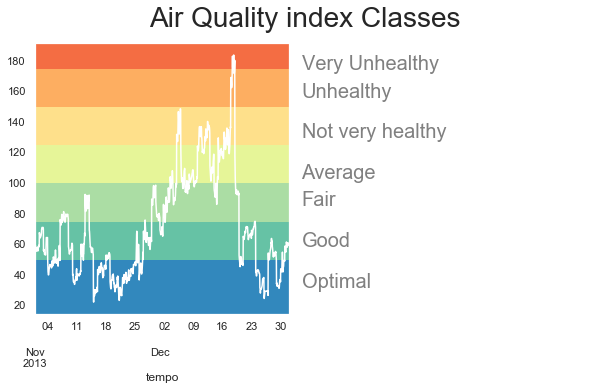

In [106]:
fig,axs=plt.subplots(ncols=2,figsize=(10,5))
diff=dataframe.index.max()-dataframe.index.min()
dataframe['AIR_QUALITY_INDEX'].plot(ax=axs[0],color='white')
rangex=[0,50,75,100,125,150,175,200,220,240,280,300]
color_array=['#1a9850','#66bd63','#a6d96a','#d9ef8b','#fee08b','#fdae61','#f46d43','#d73027','#d73027']
#color_array=['#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850']
name_array=['Optimal','Good','Fair','Average','Not very healthy','Unhealthy','Very Unhealthy']
positioner=[0.1,0.25,0.4,0.5,0.65,0.8,0.9]
color_array=['#3288bd','#66c2a5','#abdda4','#e6f598','#fee08b','#fdae61','#f46d43','#d53e4f']
i=0
for x  in rangex: 
    if i<8:
        axs[0].add_patch(Rectangle((0,rangex[i]),diff.value,rangex[i+1]-rangex[i],color=color_array[i]))
    if i<7:
          axs[1].text(x=-0.15,y=positioner[i],s=name_array[i],fontsize=20,color='grey')
    i+=1
axs[1].set_axis_off()
fig.suptitle('Air Quality index Classes',fontsize=28);

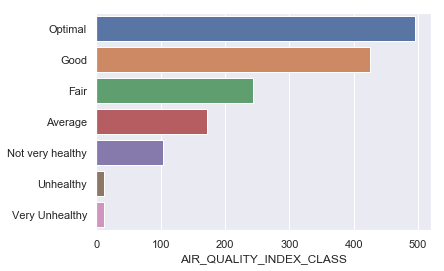

In [107]:
data=dataframe.groupby('AIR_QUALITY_INDEX_CLASS')['AIR_QUALITY_INDEX_CLASS'].count()
data.index=['Optimal','Good','Fair','Average','Not very healthy','Unhealthy','Very Unhealthy']
sns.barplot(y=data.index,x=data)

## "LA SEMPLICE"

In [108]:
def transform_score_into_label(array_of_scores):
    bool_mask=np.array(array_of_scores)
    new_array=np.array([0]*len(array_of_scores))
    new_array[bool_mask<50]=0
    new_array[(bool_mask >=50) & (bool_mask <75)]=1 
    new_array[(bool_mask >=75) & (bool_mask <100)] = 2 
    new_array[(bool_mask >=100) & (bool_mask <125)] = 3
    new_array[(bool_mask >124) & (bool_mask <150)] = 4 
    new_array[(bool_mask >149) & (bool_mask <175)] = 5
    new_array[(bool_mask>174)]=6
    return new_array


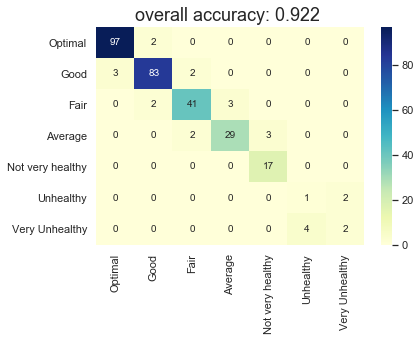

In [109]:
pollutant='AIR_QUALITY_INDEX'
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,pollutant]
## scale 
X=preprocessing.scale(X.astype('float64'))
#### split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
## i.e. number of estimators is the number of trees
model=RandomForestRegressor(n_estimators=100)
model.fit(X_train,y_train)
predictions=model.predict(X_test)
labels_predictions=transform_score_into_label(predictions)
y_test_labels=dataframe.loc[y_test.index,'AIR_QUALITY_INDEX_CLASS']
sns.heatmap(confusion_matrix(y_test_labels,labels_predictions),xticklabels=class_dictionary,yticklabels=class_dictionary,annot=True,cmap="YlGnBu");
plt.title('overall accuracy: {0} '.format(round(sum(labels_predictions==y_test_labels)/len(y_test_labels),3)),fontsize=18);

## "LA CLASSICA"  Random forest classifier...

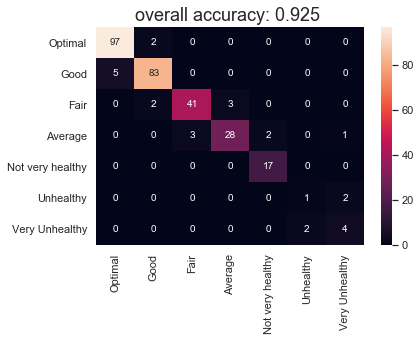

In [110]:
pollutant='AIR_QUALITY_INDEX_CLASS'
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,pollutant]
## scale 
X=preprocessing.scale(X.astype('float64'))
#### split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
## i.e. number of estimators is the number of trees

model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)
predictions=model.predict(X_test)
sns.heatmap(confusion_matrix(y_test,predictions),xticklabels=class_dictionary,yticklabels=class_dictionary,annot=True);

plt.title('overall accuracy: {0} '.format(round(sum(predictions==y_test)/len(y_test),3)),fontsize=18);


In [111]:
most_common_label=dataframe.groupby('AIR_QUALITY_INDEX_CLASS')['AIR_QUALITY_INDEX_CLASS'].count().index[0]
benchmark_classification=sum(dataframe['AIR_QUALITY_INDEX_CLASS']==most_common_label)/dataframe.shape[0]
print('benchmark for classification ',round(benchmark_classification,2))
benchmark_regression=compute_mse(dataframe['AIR_QUALITY_INDEX']-np.mean(dataframe['AIR_QUALITY_INDEX']))
print('benchmark for regression ',round(benchmark_regression,2))

benchmark for classification  0.34
benchmark for regression  1105.71
